In [1]:
# Code example of introducing samples of derivatives

# Note that the implementation is chosen to build intuition, 
# not for efficiency

In [2]:
import autograd.numpy as np_ag
import numpy as np
from autograd import hessian, jacobian

import matplotlib.pyplot as plt


In [3]:
# Define a function to estimate

tau = 1.9029+np.pi
T = 2*np.pi
aa = 0.2
bb = 3
cc = 1.1133
hh = 1
def alt(tt):
    return hh*(np.sin(tt+tau)+aa*np.cos(bb*(tt+tau))+cc)

def spe(tt):
    return hh*(np.cos(tt+tau)-bb*aa*np.sin(bb*(tt+tau)))

def acc(tt):
    return hh*(-np.sin(tt+tau)-bb**2*aa*np.cos(bb*(tt+tau)))

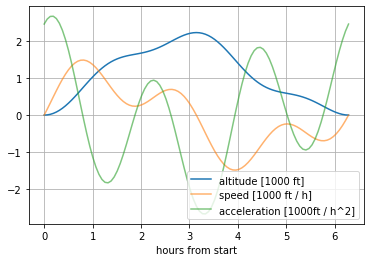

In [4]:
# Plot the underlying function with derivatives
tt_dom = np.linspace(0, T, 101)
plt.plot(tt_dom, alt(tt_dom), label='altitude [1000 ft]')
plt.plot(tt_dom, spe(tt_dom), label='speed [1000 ft / h]', alpha=0.6)
plt.plot(tt_dom, acc(tt_dom), label='acceleration [1000ft / h^2]', alpha=0.6)


plt.grid()
plt.legend()
plt.xlabel('hours from start');

In [5]:
# Define covariance function
def kk_vec(xx_vals):
    return np_ag.exp(-1/2*(np_ag.matmul(xx_vals.T, np_ag.array([1., -1.])))**2)

# Use autograd to calculate partial derivatives of the 
# covariance function
kk_jac = jacobian(kk_vec)
kk_hes = hessian(kk_vec)
kk_hes_hes = hessian(kk_hes)
kk_hes_jac = jacobian(kk_hes)

In [6]:
# List of sample locations of the function and its derivatives
# alt: altitude
# spe: speed (first derivative)
# acc: acceleration (second derivative)
example_list = [(0, 'alt'), (2, 'alt'), 
                (4, 'alt'), (2*np.pi, 'alt'),
                (2, 'spe'), (2, 'acc')]

# Set the noise level
sigma_n = 0.001

sample_locs = np.unique([xx_ii for (xx_ii, _) in example_list])

In [7]:
# List of the function and derivative values of the samples,
# with added noise
def build_samples_vec(feature_list, sigma_n):
    samples = []
    for (xx_ii, str_ii) in feature_list:
        if str_ii == 'alt':
            samples.append(alt(xx_ii)+np.random.normal(0, sigma_n))
        elif str_ii == 'spe':
            samples.append(spe(xx_ii)+np.random.normal(0, sigma_n))
        elif str_ii == 'acc':
            samples.append(acc(xx_ii)+np.random.normal(0, sigma_n))
    return samples

np.random.seed(13)
Yn = build_samples_vec(example_list, sigma_n)

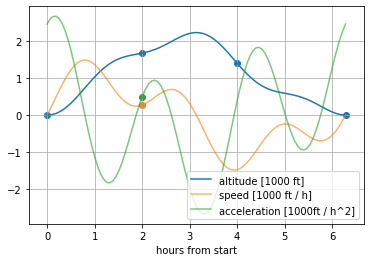

In [8]:
# Plot the samples
tt_dom = np.linspace(0, T, 101)
plt.plot(tt_dom, alt(tt_dom), label='altitude [1000 ft]')
plt.plot(tt_dom, spe(tt_dom), label='speed [1000 ft / h]', alpha=0.6)
plt.plot(tt_dom, acc(tt_dom), label='acceleration [1000ft / h^2]', alpha=0.6)

colours = {'alt': 'C0', 'spe': 'C1', 'acc': 'C2'}
for ii in range(len(example_list)):
    plt.scatter(example_list[ii][0], Yn[ii], c=colours[example_list[ii][1]])

plt.grid()
plt.legend()
plt.xlabel('hours from start');

In [9]:
# Initialise a covariance matrix to fill in

N_samp = len(example_list)
KK = np.ones((N_samp, N_samp))*np.nan
print(KK)

[[nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]]


In [10]:
# Fill in the entries not involving any derivatives

def fill_in_easy(example_list_ii, example_list_jj, KK):
    # Iterate over the first list
    for ii in range(len(example_list_ii)):
        xx_ii, str_ii = example_list_ii[ii]
        # Iterate over the second list
        for jj in range(len(example_list_jj)):
            xx_jj, str_jj = example_list_jj[jj]
            if str_ii == str_jj == 'alt':
                KK[ii, jj] = kk_vec(np.array([xx_ii, xx_jj]))
    return KK
                                    
KK = fill_in_easy(example_list, example_list, KK)      
print(np.round(KK, 2))

[[1.   0.14 0.   0.    nan  nan]
 [0.14 1.   0.14 0.    nan  nan]
 [0.   0.14 1.   0.07  nan  nan]
 [0.   0.   0.07 1.    nan  nan]
 [ nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan]]


In [11]:
# Use the Jacobian to fill in the entries that involve a
# single partial derivative

def fill_in_jacobian(example_list_ii, example_list_jj, KK):
    for ii in range(len(example_list_ii)):
        xx_ii, str_ii = example_list_ii[ii]
        for jj in range(len(example_list_jj)):
            xx_jj, str_jj = example_list_jj[jj]
            if str_ii == 'alt' and str_jj == 'spe':
                KK[ii, jj] = kk_jac(np.array([xx_ii, xx_jj]))[1]
            elif str_ii == 'spe' and str_jj == 'alt':
                KK[ii, jj] = kk_jac(np.array([xx_ii, xx_jj]))[0]
    return KK

KK = fill_in_jacobian(example_list, example_list, KK)      
print(np.round(KK, 2))

[[ 1.    0.14  0.    0.   -0.27   nan]
 [ 0.14  1.    0.14  0.    0.     nan]
 [ 0.    0.14  1.    0.07  0.27   nan]
 [ 0.    0.    0.07  1.    0.     nan]
 [-0.27 -0.    0.27  0.     nan   nan]
 [  nan   nan   nan   nan   nan   nan]]


In [12]:
# Use the Hessian to fill in the entries that involve taking
# two partial derivatives

def fill_in_hessian(example_list_ii, example_list_jj, KK):
    for ii in range(len(example_list_ii)):
        xx_ii, str_ii = example_list_ii[ii]
        for jj in range(len(example_list_jj)):
            xx_jj, str_jj = example_list_jj[jj]
            if str_ii == 'alt' and str_jj == 'acc':
                KK[ii, jj] = kk_hes(np.array([xx_ii, xx_jj]))[1, 1]
            elif str_ii == 'acc' and str_jj == 'alt':
                KK[ii, jj] = kk_hes(np.array([xx_ii, xx_jj]))[0, 0]
            elif str_ii == 'spe' and str_jj == 'spe':
                KK[ii, jj] = kk_hes(np.array([xx_ii, xx_jj]))[0, 1]
    return KK

KK = fill_in_hessian(example_list, example_list, KK)      
print(np.round(KK, 2))

[[ 1.    0.14  0.    0.   -0.27  0.41]
 [ 0.14  1.    0.14  0.    0.   -1.  ]
 [ 0.    0.14  1.    0.07  0.27  0.41]
 [ 0.    0.    0.07  1.    0.    0.  ]
 [-0.27 -0.    0.27  0.    1.     nan]
 [ 0.41 -1.    0.41  0.     nan   nan]]


In [13]:
# By using the Jacobian and Hessian of the Hessian the 
# final entries can be calculated

def fill_in_rest(example_list_ii, example_list_jj, KK):
    for ii in range(len(example_list_ii)):
        xx_ii, str_ii = example_list_ii[ii]
        for jj in range(len(example_list_jj)):
            xx_jj, str_jj = example_list_jj[jj]
            if str_ii == 'spe' and str_jj == 'acc':
                KK[ii, jj] = kk_hes_jac(np.array([xx_ii, xx_jj]))[0, 1, 1]
            elif str_ii == 'acc' and str_jj == 'spe':
                KK[ii, jj] = kk_hes_jac(np.array([xx_ii, xx_jj]))[0, 0, 1]
            elif str_ii == 'acc' and str_jj == 'acc':
                KK[ii, jj] = kk_hes_hes(np.array([xx_ii, xx_jj]))[0, 0, 1, 1]
    return KK

KK = fill_in_rest(example_list, example_list, KK)      
print(np.round(KK, 2))

[[ 1.    0.14  0.    0.   -0.27  0.41]
 [ 0.14  1.    0.14  0.    0.   -1.  ]
 [ 0.    0.14  1.    0.07  0.27  0.41]
 [ 0.    0.    0.07  1.    0.    0.  ]
 [-0.27 -0.    0.27  0.    1.   -0.  ]
 [ 0.41 -1.    0.41  0.   -0.    3.  ]]


In [14]:
# Function that puts the above together

def build_cov_composite(example_list_ii, example_list_jj):
    N = len(example_list_ii)
    M = len(example_list_jj)
    KK = np.ones((N, M))*np.nan
    KK = fill_in_easy(example_list_ii, example_list_jj, KK)      
    KK = fill_in_jacobian(example_list_ii, example_list_jj, KK)      
    KK = fill_in_hessian(example_list_ii, example_list_jj, KK)      
    KK = fill_in_rest(example_list_ii, example_list_jj, KK)      
    return KK

In [15]:
# Estimate the mean and variance of altitude throughout the day

def get_mean_var(feature_list, Yn, dom_list, sigma_n):
    Knn = build_cov_composite(feature_list, feature_list) 
    N_samp, _ = np.shape(Knn)
    M_dom = len(dom_list)
    Kmm = build_cov_composite(dom_list, dom_list)
    Knm = build_cov_composite(feature_list, dom_list)
    
    common_term = np.matmul(Knm.T, np.linalg.inv(Knn + 
                                np.eye(N_samp)*sigma_n**2))
    
    mu = np.matmul(common_term, Yn)
    var = Kmm - np.matmul(common_term, Knm)
    
    return mu, var

# Estimate altitude values 
dom_list = [[tt, 'alt'] for tt in tt_dom]

mu, var = get_mean_var(example_list, Yn, dom_list, sigma_n)
std = np.sqrt(np.diag(var))


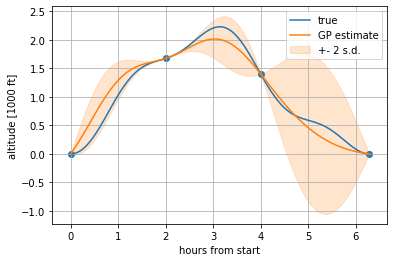

In [16]:
# Plot estimate of the altitude

plt.plot(tt_dom, alt(tt_dom), label='true')
plt.scatter(sample_locs, alt(sample_locs))

plt.grid()
plt.xlabel('hours from start')
plt.ylabel('altitude [1000 ft]')

plt.plot(tt_dom, mu, label='GP estimate')
plt.fill_between(tt_dom, mu+2*std, mu-2*std, color='C1', 
                 alpha=0.2, label='+- 2 s.d.')
plt.legend();

In [17]:
# Get new estimate ignoring samples of the derivatives
example_list_just_alt = [(xx_ii, str_ii) for (xx_ii, str_ii) in example_list if str_ii == 'alt']
Yn_just_alt = [Yn[ii] for ii in range(len(Yn)) if example_list[ii][1] == 'alt']

mu_just_alt, var_just_alt = get_mean_var(example_list_just_alt, Yn_just_alt, dom_list, sigma_n)
std_just_alt = np.sqrt(np.diag(var_just_alt))

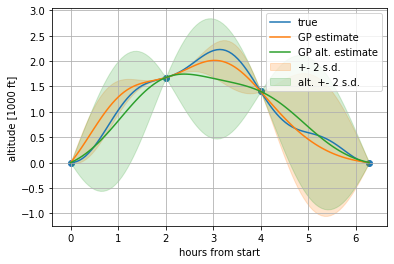

In [18]:
# Plot the two estimates of altitude to compare

plt.plot(tt_dom, alt(tt_dom), label='true')
plt.scatter(sample_locs, alt(sample_locs))

plt.grid()
plt.xlabel('hours from start')
plt.ylabel('altitude [1000 ft]')

plt.plot(tt_dom, mu, label='GP estimate')
plt.fill_between(tt_dom, mu+2*std, mu-2*std, color='C1', 
                 alpha=0.2, label='+- 2 s.d.')

plt.plot(tt_dom, mu_just_alt, label='GP alt. estimate')
plt.fill_between(tt_dom, mu_just_alt+2*std_just_alt, 
                 mu_just_alt-2*std_just_alt, 
                 color='C2', alpha=0.2, label='alt. +- 2 s.d.')
plt.legend();